<a href="https://colab.research.google.com/github/akaksusha/FreeCodeCamp-Pandas-Real-Life-Example/blob/master/project_a_b_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт необходимых для исследования библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка и подготовка данных к работе. Описание входящих параметров   

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/итоговый прооект/marketing_AB.csv')
data.head()


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


В таблице представлены следущие данные:

*   **Unnamed: 0** - индекс. Повторяет автоматические индаксы датасета, поэтому в дальнейшем будет удален
*   **user id**	- уникальный номер пользователя
*   **test group**	-  ad  если пользователю была показана реклама, psa  в противоположном случае
*   **converted**	-  True  покупка была совершена, False  покупки не было
*   **total ads**	- общее количество объявлений, которое было показано пользователю
*   **most ads day**	- день недели, в который пользователь увидел наибольшее количество объявлений
*  **most ads hour** - час, в который пользователь увидел наибольшее количество объявлений

test group,	converted, most ads day, 	most ads hour - являются номинальными значениями

**Задача**: исследовать предоставленные данные, выяснить, была ли рекламная кампания успешной и определить насколько.  





---
Проверка пропусков  и дубликатов, удаление лишнего столбца индексов



In [ ]:
print(data.isna().sum())
data.info()
data.drop('Unnamed: 0', axis = 1)

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


---
Разделим исходный датасет на тест (если была показана реклама) и контроль (если была показана только социальная реклама или на месте объявления было пусто).

In [ ]:
data_test = data[data['test group'] == 'ad']
data_control = data[data['test group'] == 'psa']

# Статический анализ

Конверсия в покупку тестовой и контрольной группы

In [ ]:
conv_test = sum(data_test[data_test['converted'] == 1]['converted'])/data_test.shape[0]
conv_control = sum(data_control[data_control['converted'] == 1]['converted'])/data_control.shape[0]
print('Конверсия в покупку тестовой группы', round(conv_test, 4)*100,'%', '\nКонверсия в покупку контрольной группы',round(conv_control, 4)*100,'%')

Конверсия в покупку тестовой группы 2.55 % 
Конверсия в покупку контрольной группы 1.79 %


Для тестовой группы конверсия оказалась почти в 2 раза выше.
Но необходимо проверить, является ли это статистически значимым различием. Так как данные являются номинальными, построим таблицу сопряженности, содержащую данные о количестве покупок для тестовой и контрольной выборок.
Для наглядности построим тепловую карту.

test group      ad    psa     All
converted                        
False       550154  23104  573258
True         14423    420   14843
All         564577  23524  588101


<Axes: xlabel='test group', ylabel='converted'>

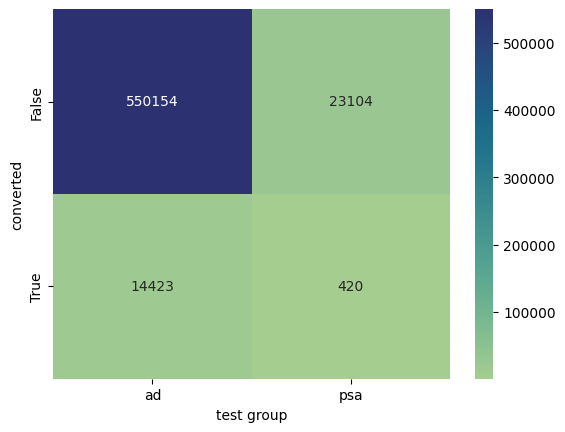

In [ ]:
cr_tab = pd.crosstab(data['converted'], data['test group'], margins=True)
print(cr_tab)
sb.heatmap(cr_tab.iloc[:-1,:-1],annot=True,fmt=".0f",cmap="crest")


## хи-квадрат Пирсона

H0: показ рекламных объявлений увеличивает конверсию в покупку.

Для определения статистической значимости воспользуемся критерием хи-кварат Пирсона.

In [ ]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(cr_tab)
alpha = 0.01
if p<alpha:
  print('Различия статистически значимы')
else:
  print('Различия статистически не значимы')


Различия статистически значимы


Выбранный критерий показал, что различия являются статистически значимы c 99% веротяностью (alpha = 0.01). Гипотеза об успешности рекламной кампании принимается.

---

## Критерий Байеса

В рамках исследования воспользуемся так же [критерием  Байеса](https://academy.yandex.ru/journal/prostoy-gid-po-bayesovskomu-a-b-testirovaniyu-na-python) для проверки статистической значимости. Этот критерий  позволяет определить насколько была успешна кампания, т.е. на сколько вырос коэффициент конверсии.

In [ ]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])


In [ ]:
from scipy.stats import beta
import numpy as np


#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl,convs_ctrl= cr_tab.loc[False,'psa'], cr_tab.loc[True,'psa']
imps_test, convs_test= cr_tab.loc[False,'ad'], cr_tab.loc[True,'ad']

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

prob=calc_prob_between(beta_T, beta_C)

print (f"Тестовый вариант увеличил коэффициент конверсии на  {lift*100:2.2f}% с {prob*100:2.1f}% вероятностью.")


Тестовый вариант увеличил коэффициент конверсии на  43.89% с 100.0% вероятностью.


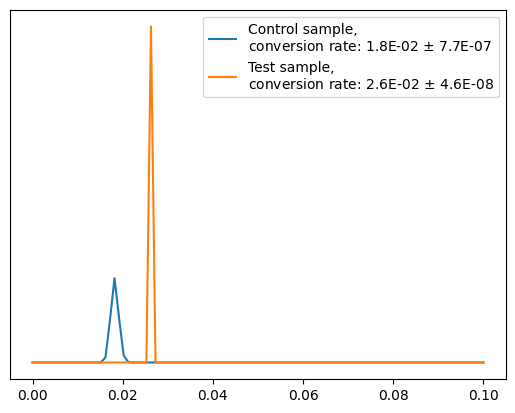

In [ ]:
import matplotlib.pyplot as plt

def calc_beta_mode(a, b):
   # '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0, lsup=0.1):
    #'''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample,\nconversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend(loc = 'upper right')
    plt.show()

plot([beta_C, beta_T], names=["Control", "Test"])

Критерий Байеса для А/В тестов показал, что различия в конверсиях являются статистически значимымыми и вероятностью 100%.

___

# Исследование распределений конверсий по дням недели и часам

Далее перейдем к исследованию конверсий в покупку по дням недели и часам. Для удобства создадим два новых dataframe:


*   conv - содержит данные о конверсиях по каждому дню;
*   conv_h - содержит данные о конверсиях за каждый час.



<Figure size 640x480 with 0 Axes>

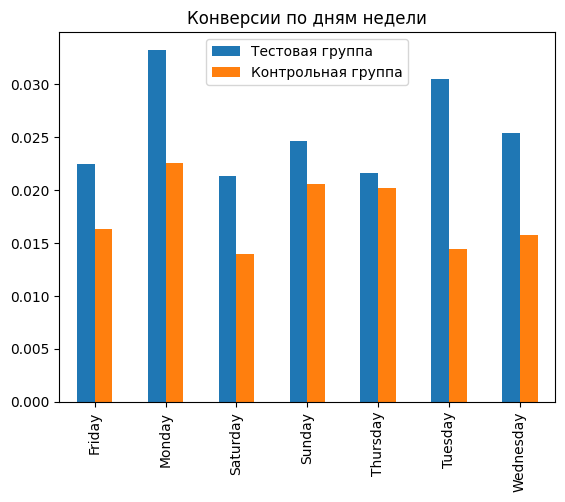

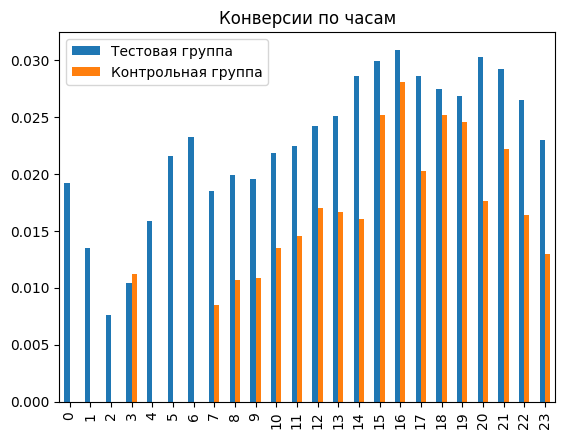

In [ ]:
conv_test_days = data_test[data_test['converted'] == 1]['most ads day'].value_counts()/data_test['most ads day'].value_counts()
conv_control_days = data_control[data_control['converted'] == 1]['most ads day'].value_counts()/data_control['most ads day'].value_counts()

conv_test_hours = data_test[data_test['converted'] == True]['most ads hour'].value_counts()/data_test['most ads hour'].value_counts()
conv_control_hours = data_control[data_control['converted'] == True]['most ads hour'].value_counts()/data_control['most ads hour'].value_counts()

conv = pd.concat([conv_test_days,conv_control_days], axis = 1)
conv.columns = [['conv test days','conv control days']]
plt.figure(#figsize = (12,5)
)
#plt.subplot(1,1,1)
conv.plot(kind = 'bar')
plt.legend(['Тестовая группа','Контрольная группа'])
plt.title('Конверсии по дням недели')

conv_h = pd.concat([conv_test_hours,conv_control_hours], axis = 1)
conv_h.columns = [['conv test hours','conv control hours']]
#plt.subplot(1,2,2)
conv_h.plot(kind = 'bar')
plt.title('Конверсии по часам')
plt.legend(['Тестовая группа','Контрольная группа'])


По неделям конверсия тестовой группы всегда выше, чем контрольной. По часам - в ночные часы контрольная группа почти не совершала покупки, однако, конверсия в 3 часа у контрольной группы выше, чем у тестовой.

Перейдем к относительным единицам, для этого посмотрим, во сколько раз конверсии тестовой группы выше, чем у контрольной. Часы, в которые контрольная группа не совершала покупки, рассматриваться не будут.

In [ ]:
conv['division'] = conv_test_days / conv_control_days
conv_h['division'] = conv_test_hours / conv_control_hours
conv_h = conv_h.dropna()

Text(0.5, 1.0, 'Конверсии по дням недели')

<Figure size 800x500 with 0 Axes>

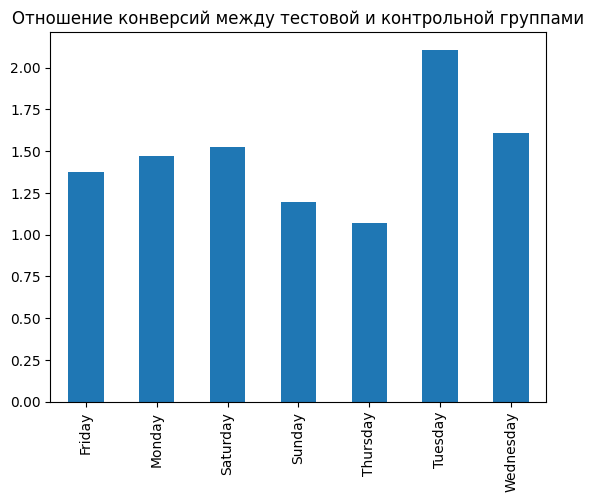

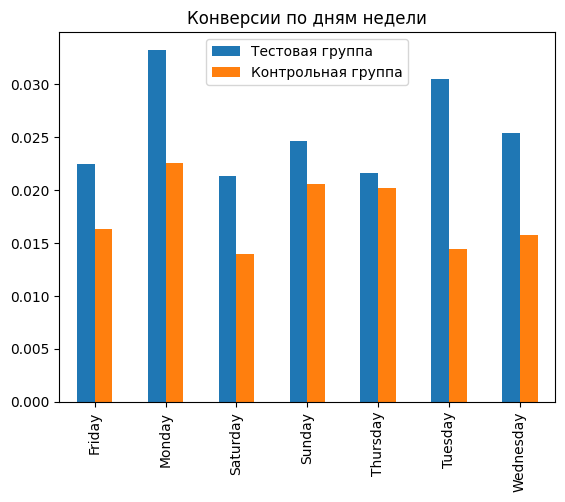

In [ ]:
plt.figure(figsize = (8,5))
f1 = conv['division'].plot(kind = 'bar')
plt.title('Отношение конверсий между тестовой и контрольной группами')
f1.get_legend().remove()

f2 = conv[['conv test days','conv control days']].plot(kind = 'bar')
plt.legend(['Тестовая группа','Контрольная группа'])
plt.title('Конверсии по дням недели')

<Figure size 1200x1000 with 0 Axes>

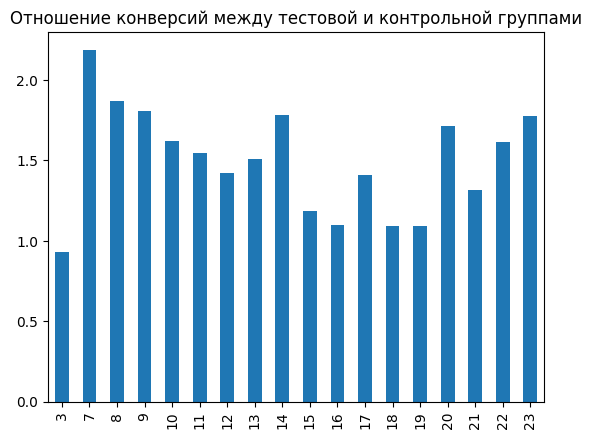

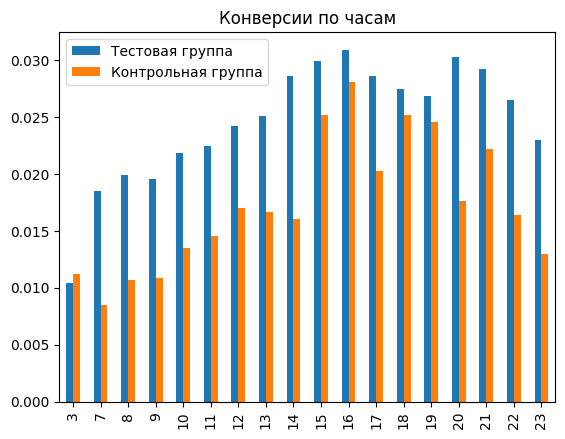

In [ ]:
plt.figure(figsize = (12,10))

f3 = conv_h['division'].plot(kind = 'bar')
plt.title('Отношение конверсий между тестовой и контрольной группами')
f3.get_legend().remove()

f4 = conv_h[['conv test hours','conv control hours']].plot(kind = 'bar')
plt.title('Конверсии по часам')
plt.legend(['Тестовая группа','Контрольная группа'])

Оптимальное время для показа рекламы - Четверг, оптимальное время - 14 часов.
Однако, использование этих данных может быть нецелесообразным, тк не указано количество объявлений, которые были показаны в данное время.

---



# Определение оптимального количества рекламных объявлений

Теперь проанализируем общее количество объявлений, которые были показаны пользователям.
Работать будем только с тестовой выборкой, тк пользователям контрольной группы реклама не была показана (на месте рекламного объявления ничего не было или была показана социальная реклама).

Для удобства исследования создадим новый dataframe, который будет содержать данные о конверсиях по количеству объявлений.

**number ads** - количество объявлений,

**conversation** - конверсия в покупку

In [ ]:
# группировка по количеству показанных объявлений пользователей, совершивших покупку
ads_fr = data_test[data_test['converted'] == True][['user id','total ads']].groupby(['total ads']).count()
ads_fr.columns = ['number of users']
# группировка по количеству показанных объявлений всех пользователей
ads_fr1 = data_test[['user id','total ads']].groupby(['total ads']).count()
ads_fr1.columns = ['number of users']
#расчет конверсии по количеству показанных объявлений
ads = ads_fr/ads_fr1#[ads_fr1['user id'] > 38]
ads = ads.reset_index()
ads.columns = ['number ads', 'conversation']
#заполнение NaN значений нулями, тк туда попали только объявления, после просмотра которых покупок не было
ads = ads.fillna(0)
ads

,number ads,conversation
0,1,0.001584
1,2,0.002400
2,3,0.002818
3,4,0.003616
4,5,0.003283
...,...,...
798,1491,1.000000
799,1632,0.000000
800,1680,1.000000
801,1778,1.000000


Для наглядности построим график в виде точечной диаграммы.

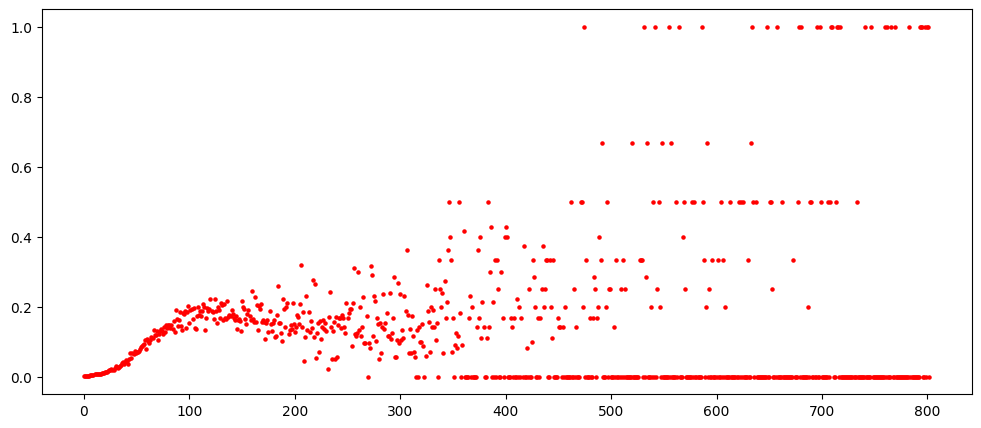

In [ ]:
plt.figure(figsize=(12,5))
#plt.subplot(1,2,1)
#plt.scatter(ads.index, ads['conversation'])
#plt.subplot(1,2,2)
plt.scatter(ads.index, ads['conversation'], color = 'red', s = 5)


Заметим, что до 200-300 объявлений распределение выглядит достаточно равномерным. Однако, с увеличением количества объявлений значение конверсии становится неоднородным.

Это может быть связано с уменьшением частоты показа объявлений, проверим эту гипотезу.

(0.0, 40000.0)

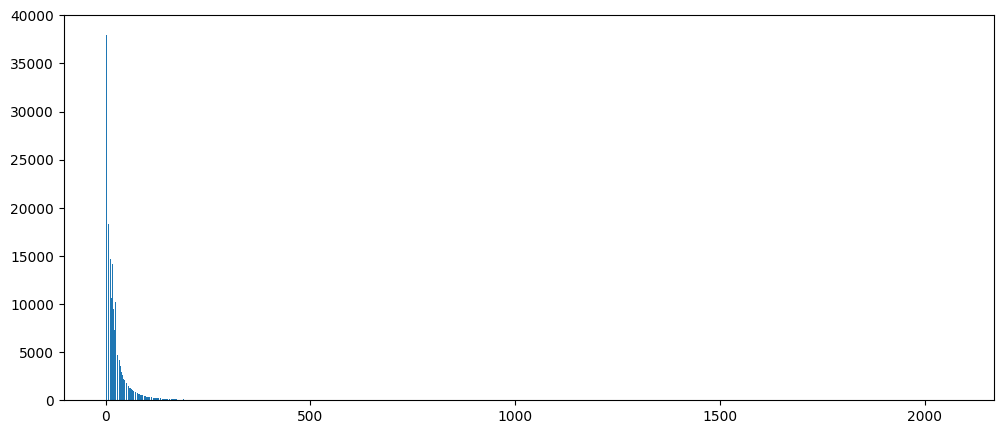

In [ ]:
ff1 = plt.figure(figsize=(12,5))

plt.bar( ads_fr1.index, ads_fr1['number of users'])
#plt.xlim(0, 1500)
plt.ylim(0, 40000)

По графику видно, что количество рекламных объявлений практически экспоненциально угасает. Масштабируем график, чтобы посмотреть какому числу пользователей было показано 200-300 реклам.

(0.0, 500.0)

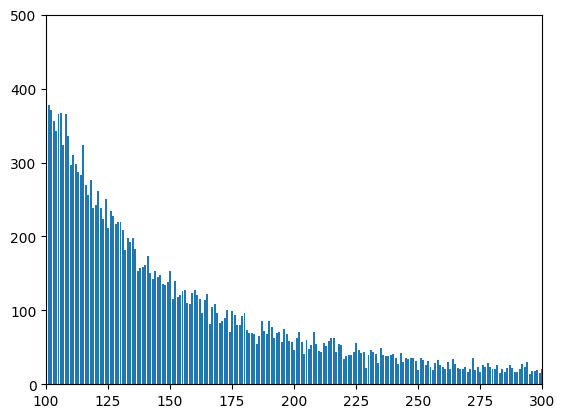

In [ ]:
plt.bar( ads_fr1.index, ads_fr1['number of users'])
plt.xlim(100, 300)
plt.ylim(0, 500)

Эмпирически обозначим для себя 200 рекламных объявлений как граничное значение. Количество пользователей, которым было показано более 200 реклам меньше 100, данные будут являться нерепрезентативными, что мы и видели по диаграмме рассеяния.

In [ ]:
ads_fr1[ads_fr1.index < 200]

,number of users
total ads,
1,54298
2,37911
3,27328
4,22401
5,28024
...,...
195,57
196,75
197,68


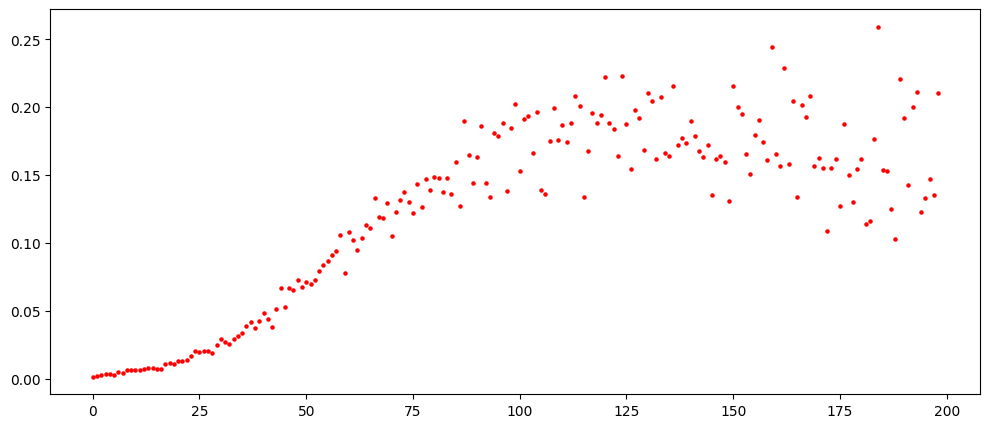

In [ ]:
ads_model = ads_fr[ads_fr.index < 200]/ads_fr1[ads_fr1.index < 200]
ads_model = ads_model.reset_index()
ads_model.columns = ['number ads', 'conversation']
#заполнение NaN значений нулями, тк туда попали только объявления, после просмотра которых покупок не было
ads_model = ads_model.fillna(0)
ads
plt.figure(figsize=(12,5))
#plt.subplot(1,2,1)
#plt.scatter(ads.index, ads['conversation'])
#plt.subplot(1,2,2)
plt.scatter(ads_model.index, ads_model['conversation'], color = 'red', s = 5)

In [ ]:
def polyfit(x, y, degree):
 results = {}
 coeffs = np.polyfit(x, y, degree)
 p = np.poly1d(coeffs)
 #calculate r-squared
 yhat = p(x)
 ybar = np.sum(y)/len(y)
 ssreg = np.sum((yhat-ybar)**2)
 sstot = np.sum((y - ybar)**2)
 results = round(ssreg / sstot, 3)

 return results


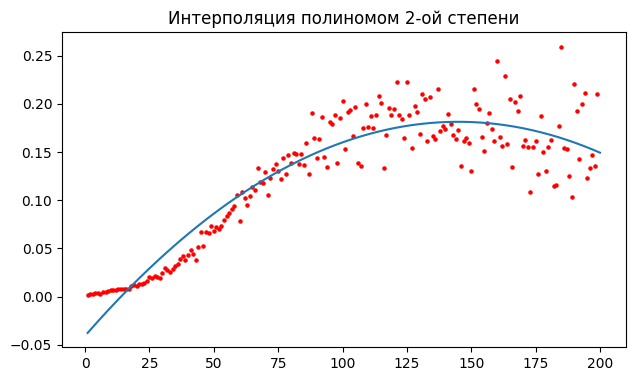


R-квадрат 0.866 



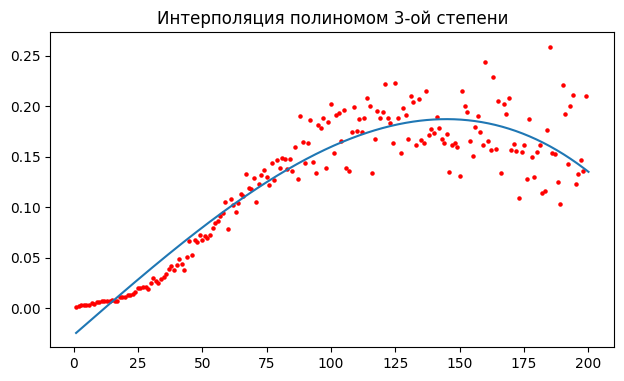


R-квадрат 0.872 



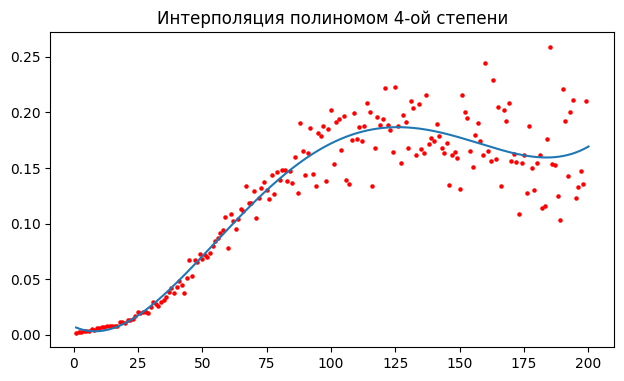


R-квадрат 0.898 



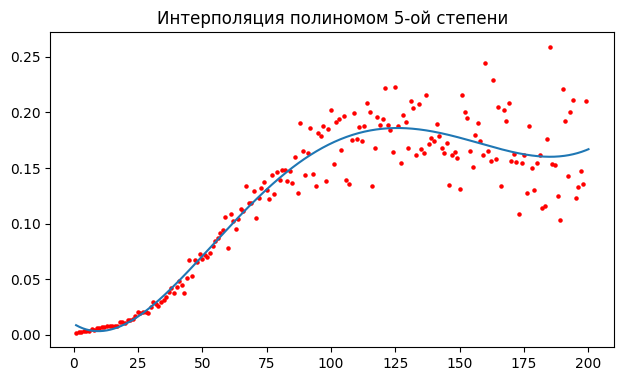


R-квадрат 0.898 



In [ ]:
x = ads_model['number ads']
y = ads_model['conversation']
#polynomial fit with degree = 3

plt.figure(figsize=(16,9))
model = np.poly1d(np.polyfit(x, y, 2))
plt.subplot(221)
#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 200, 600)
plt.scatter(x, y, color = 'red', s = 5)
plt.plot(polyline, model(polyline))
plt.title('Интерполяция полиномом 2-ой степени')

plt.show()
print('\nR-квадрат',polyfit(x, y, 2),'\n')

plt.figure(figsize=(16,9))
plt.subplot(222)

model = np.poly1d(np.polyfit(x, y, 3))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 200, 600)
plt.scatter(x, y, color = 'red', s = 5)
plt.plot(polyline, model(polyline))
plt.title('Интерполяция полиномом 3-ой степени')

plt.show()
print('\nR-квадрат',polyfit(x, y, 3),'\n')

plt.figure(figsize=(16,9))
plt.subplot(223)

model = np.poly1d(np.polyfit(x, y, 4))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 200, 600)
plt.scatter(x, y, color = 'red', s = 5)
plt.plot(polyline, model(polyline))
plt.title('Интерполяция полиномом 4-ой степени')

plt.show()
print('\nR-квадрат',polyfit(x, y, 4), '\n')

plt.figure(figsize=(16,9))
plt.subplot(224)

model = np.poly1d(np.polyfit(x, y, 5))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 200, 600)
plt.scatter(x, y, color = 'red', s = 5)
plt.plot(polyline, model(polyline))
plt.title('Интерполяция полиномом 5-ой степени')

plt.show()
print('\nR-квадрат',polyfit(x, y, 5),'\n')



Полином 4-ой степени лучше всего интреполирует данные. R-квадрат для полиномов 4 и 5 степени одинаковый, целесообразнее выбрать полином меньшей степени для упрощения расчетов.



Найдем количество объявлений при котором конверсия максимальна.

In [ ]:
model = np.poly1d(np.polyfit(x, y, 4))
df1 = pd.DataFrame({'x': polyline, 'y':model(polyline)})
round(df1.sort_values(by = 'y', ascending = False)['x'][:1])

376    126.0
Name: x, dtype: float64

# Выводы:

*   Оценка эффективности рекламной кампании была оценена с помощью хи-квадрата Пирсона (нулевая гипотеза была принята с вероятностью 99,9%). Критерий Байеса позволил оценить эффективность проведенной кампании (тестовый вариант увеличил коэффициент конверсии на  43.89% с 100.0% вероятностью.)

*   Оптимальное время для показа рекламы - Четверг, оптимальное время - 14 часов. Для определения статистической значимости этих параметром недостаточно данных, не указано количество объявлений, которое было показано в это время каждому из пользователей.


*   Анализ количества рекламных объявлений показал, что наилучшая конверсия (0,19)  достигается при ~126 объвлениях.





